# Train PyTorch

In [1]:
import torch
import torch.onnx
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
class LeNetPT(nn.Module):
    def __init__(self):
        super(LeNetPT, self).__init__()
        # Convolutional encoder
        self.conv1 = nn.Conv2d(1, 6, 5)  # 1 input channel, 6 output channels, 5x5 kernel
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 input channels, 16 output channels, 5x5 kernel

        # Fully connected layers / Dense block
        self.fc1 = nn.Linear(16 * 4 * 4, 120) # 256 * 120
        self.fc2 = nn.Linear(120, 84)         # 120 inputs, 84 outputs
        self.fc3 = nn.Linear(84, 10)          # 84 inputs, 10 outputs (number of classes)

    def forward(self, x):
        # Convolutional block
        x = F.avg_pool2d(F.sigmoid(self.conv1(x)), (2, 2)) # Convolution -> Sigmoid -> Avg Pool
        x = F.avg_pool2d(F.sigmoid(self.conv2(x)), (2, 2)) # Convolution -> Sigmoid -> Avg Pool

        # Flattening
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)  # No activation function here, will use CrossEntropyLoss later
        return x

In [3]:
class LeNet_(nn.Module):
    def __init__(self, features=(6, 16, 120, 84)):
        super(LeNet, self).__init__()

        features = list(features)
        if len(features) == 3:
            features.append(None)

        f1, f2, f3, f4 = features

        self.conv1 = nn.Conv2d(1, f1, kernel_size=5)
        self.conv2 = nn.Conv2d(f1, f2, kernel_size=5)
        self.fc1 = nn.Linear(f2 * 4 * 4, f3)
        if f4 is not None:
            self.fc2 = nn.Linear(f3, f4)
            self.fc3 = nn.Linear(f4, 10)
        else:
            self.fc2 = nn.Linear(f3, 10)
            self.fc3 = None

    def forward(self, x):
        # Note that tanh activation does a better job at keeping activations in a predictable
        # range. This means that fewer bits are needed for quantization!
        x = torch.tanh(self.conv1(x))
        x = torch.nn.functional.avg_pool2d(x, 2)
        x = torch.tanh(self.conv2(x))
        x = torch.nn.functional.avg_pool2d(x, 2)
        x = x.flatten(1)
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        if self.fc3 is not None:
            x = self.fc3(torch.tanh(x))
        return x

In [73]:
from torchvision.transforms import ToTensor
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def load_dataset(batch_size=256):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = torchvision.datasets.MNIST(
        root='./data', train=True, transform=ToTensor(), download=True)
    test_dataset = torchvision.datasets.MNIST(
        root='./data', train=False, transform=ToTensor())

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_dataset, test_dataset


def train(model, train_dataset, learning_rate=0.001, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()  # Set the model to training mode

    # Train the model
    for epoch in range(num_epochs):
        total_loss = 0
        # Wrap the train_dataset with tqdm for a progress bar
        for images, labels in tqdm(train_dataset, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images = images.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Print average loss for the epoch
        print(f'Epoch [{epoch + 1}/{num_epochs}], Average Loss: {total_loss / len(train_dataset):.4f}')


def evaluate(model, test_dataset):
    model.to(device)
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for images, labels in test_dataset:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f'Test Accuracy: {accuracy:.2f}%')


In [6]:
import matplotlib.pyplot as plt

def plot_mnist_images(dataset, indices = []):

    if not indices:
        fig, axes = plt.subplots(1, len(dataset), figsize=(12, 4))
        
        for i in range(len(axes)):
            image, label = dataset[i]
            ax = axes[i]
            
            image = image.squeeze()  # Remove channel dimension

            ax.imshow(image, cmap='gray')
            ax.set_title(f'Label: {label}')
            ax.axis('off')

        plt.show()
        return

    fig, axes = plt.subplots(1, len(indices), figsize=(12, 4))
    if len(indices) == 1:  # If only one index is provided, wrap axes in a list
        axes = [axes]
    
    for ax, idx in zip(axes, indices):
        image, label = dataset[idx]
        image = image.squeeze()  # Remove channel dimension

        ax.imshow(image, cmap='gray')
        ax.set_title(f'Label: {label}')
        ax.axis('off')

    plt.show()


In [29]:
# Load the dataset
train_loader, test_loader, train_dataset, test_dataset = load_dataset()

In [8]:
# Train the model (in a separate cell)
model_pt = LeNetPT().to(device)
train(model_pt, train_loader)

Epoch 1/10:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1/10: 100%|██████████| 235/235 [00:01<00:00, 148.10it/s]


Epoch [1/10], Average Loss: 2.0114


Epoch 2/10: 100%|██████████| 235/235 [00:03<00:00, 64.70it/s]


Epoch [2/10], Average Loss: 0.6618


Epoch 3/10: 100%|██████████| 235/235 [00:04<00:00, 48.84it/s]


Epoch [3/10], Average Loss: 0.3644


Epoch 4/10: 100%|██████████| 235/235 [00:04<00:00, 48.26it/s]


Epoch [4/10], Average Loss: 0.2794


Epoch 5/10: 100%|██████████| 235/235 [00:04<00:00, 48.41it/s]


Epoch [5/10], Average Loss: 0.2283


Epoch 6/10: 100%|██████████| 235/235 [00:01<00:00, 138.98it/s]


Epoch [6/10], Average Loss: 0.1911


Epoch 7/10: 100%|██████████| 235/235 [00:01<00:00, 158.04it/s]


Epoch [7/10], Average Loss: 0.1642


Epoch 8/10: 100%|██████████| 235/235 [00:01<00:00, 166.21it/s]


Epoch [8/10], Average Loss: 0.1442


Epoch 9/10: 100%|██████████| 235/235 [00:01<00:00, 167.82it/s]


Epoch [9/10], Average Loss: 0.1294


Epoch 10/10: 100%|██████████| 235/235 [00:01<00:00, 157.28it/s]

Epoch [10/10], Average Loss: 0.1157


In [97]:
model_pt = model_pt.to(device)
evaluate(model_pt, test_loader)

Test Accuracy: 96.85%


In [14]:
torch.save(model_pt.state_dict(), "../model/LeNet_pt_model.pth")

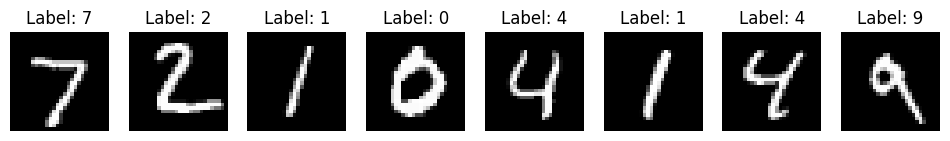

In [10]:
plot_mnist_images(test_dataset, [0,1,2,3,4,5,6,7])

# Convert 2 Tensorflow Model

In [96]:
import tensorflow as tf

# Load and preprocess the MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

# Define the LeNet model in TensorFlow
model_tf = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(6, kernel_size=(5, 5), activation='sigmoid', input_shape=(28, 28, 1)),
    tf.keras.layers.AvgPool2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(16, kernel_size=(5, 5), activation='sigmoid'),
    tf.keras.layers.AvgPool2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='sigmoid'),
    tf.keras.layers.Dense(84, activation='sigmoid'),
    tf.keras.layers.Dense(10)  # Assuming 10 classes
])

## Transfer Weights

In [98]:
pytorch_weights = []
for layer in model_pt.children():
    if isinstance(layer, torch.nn.Conv2d) or isinstance(layer, torch.nn.Linear):
        weights = layer.weight.data.cpu().numpy()
        biases = layer.bias.data.cpu().numpy()
        pytorch_weights.append((weights, biases))

In [100]:
for layer in model_pt.children():
    if isinstance(layer, torch.nn.Conv2d) or isinstance(layer, torch.nn.Linear):
        print(layer.weight.data.shape)

torch.Size([6, 1, 5, 5])
torch.Size([16, 6, 5, 5])
torch.Size([120, 256])
torch.Size([84, 120])
torch.Size([10, 84])


In [108]:
import numpy as np
import torch
import tensorflow as tf
pt_layers = [layer for layer in model_pt.children() if isinstance(layer, (torch.nn.Conv2d, torch.nn.Linear))]
tf_layers = [layer for layer in model_tf.layers if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense))]

def transfer_weights(model_pt, model_tf):
    model_pt.eval()
    model_tf.trainable = False

    for i, (pt_layer, tf_layer) in enumerate(zip(pt_layers, tf_layers)):
        pt_weights = pt_layer.state_dict()
        pt_weights = [w.cpu().numpy() for w in pt_weights.values()]

        if isinstance(tf_layer, tf.keras.layers.Conv2D) and isinstance(pt_layer, torch.nn.Conv2d):
            transposed_weights = np.transpose(pt_weights[0], [2, 3, 1, 0])
            assert transposed_weights.shape == tf_layer.weights[0].shape, "Shape mismatch in Conv2D layer"
            tf_layer.set_weights([transposed_weights, pt_weights[1]])

        elif isinstance(tf_layer, tf.keras.layers.Dense) and isinstance(pt_layer, torch.nn.Linear):
            assert pt_weights[0].T.shape == tf_layer.weights[0].shape, "Shape mismatch in Dense layer"
            tf_layer.set_weights([pt_weights[0].T, pt_weights[1]])  # Transpose weights for dense layers

        else:
            print(f"Layer mismatch or configuration issue in layer {i}: {tf_layer.name}")


transfer_weights(model_pt, model_tf)


In [110]:
def compare_weights(pt_layer, tf_layer):
    pt_weights = [w.cpu().detach().numpy() for w in pt_layer.state_dict().values()]
    tf_weights = tf_layer.get_weights()

    if isinstance(pt_layer, torch.nn.Conv2d):
        pt_weights[0] = np.transpose(pt_weights[0], [2, 3, 1, 0])  # Transpose for Conv2D
    elif isinstance(pt_layer, torch.nn.Linear):
        pt_weights[0] = pt_weights[0].T  # Transpose for Linear

    for pt_w, tf_w in zip(pt_weights, tf_weights):
        if not np.allclose(pt_w, tf_w, atol=1e-6):
            return False
    return True


for pt_layer, tf_layer in zip(pt_layers, tf_layers):
    if not compare_weights(pt_layer, tf_layer):
        print(f"Weight mismatch detected in layer: {type(pt_layer)}")


In [111]:
# Compile the model
model_tf.compile(optimizer='adam',
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

# Evaluate the model
test_loss, test_acc = model_tf.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 0s - loss: 5.7077 - accuracy: 0.0790 - 280ms/epoch - 894us/step

Test accuracy: 0.07900000363588333


In [86]:
import torch
import torch.onnx
import onnx

# Define some example input data (adjust the shape to match your input)
input_data = torch.randn(1, 1, 28, 28) # Example input for LeNet

# Export the PyTorch model to ONNX
onnx_filename = "../model/lenet_tf.onnx"
torch.onnx.export(model_pt.cpu(), input_data, onnx_filename, verbose=True, input_names=['input'], output_names=['output'])


Exported graph: graph(%input : Float(1, 1, 28, 28, strides=[784, 784, 28, 1], requires_grad=0, device=cpu),
      %conv1.weight : Float(6, 1, 5, 5, strides=[25, 25, 5, 1], requires_grad=1, device=cpu),
      %conv1.bias : Float(6, strides=[1], requires_grad=1, device=cpu),
      %conv2.weight : Float(16, 6, 5, 5, strides=[150, 25, 5, 1], requires_grad=1, device=cpu),
      %conv2.bias : Float(16, strides=[1], requires_grad=1, device=cpu),
      %fc1.weight : Float(120, 256, strides=[256, 1], requires_grad=1, device=cpu),
      %fc1.bias : Float(120, strides=[1], requires_grad=1, device=cpu),
      %fc2.weight : Float(84, 120, strides=[120, 1], requires_grad=1, device=cpu),
      %fc2.bias : Float(84, strides=[1], requires_grad=1, device=cpu),
      %fc3.weight : Float(10, 84, strides=[84, 1], requires_grad=1, device=cpu),
      %fc3.bias : Float(10, strides=[1], requires_grad=1, device=cpu)):
  %/conv1/Conv_output_0 : Float(1, 6, 24, 24, strides=[3456, 576, 24, 1], requires_grad=0, dev

In [88]:
import onnx
from onnx_tf.backend import prepare

# Load the ONNX model
onnx_model = onnx.load(onnx_filename)

# Convert
tf_rep = prepare(onnx_model)

# Export the model to TensorFlow format
tf_rep.export_graph('../model/converted_model')

INFO:absl:Function `__call__` contains input name(s) x with unsupported characters which will be renamed to transpose_12_x in the SavedModel.
INFO:absl:Found untraced functions such as gen_tensor_dict while saving (showing 1 of 1). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../model/converted_model/assets


INFO:tensorflow:Assets written to: ../model/converted_model/assets
INFO:absl:Writing fingerprint to ../model/converted_model/fingerprint.pb


## Retrain TF model

In [113]:
# Define the LeNet model in TensorFlow
model_tf = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(6, kernel_size=(5, 5), activation='sigmoid', input_shape=(28, 28, 1)),
    tf.keras.layers.AvgPool2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(16, kernel_size=(5, 5), activation='sigmoid'),
    tf.keras.layers.AvgPool2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(120, activation='sigmoid'),
    tf.keras.layers.Dense(84, activation='sigmoid'),
    tf.keras.layers.Dense(10)  # Assuming 10 classes
])

# Compile the model
model_tf.compile(optimizer='adam',
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

# Train the model
history = model_tf.fit(train_images, train_labels, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model
test_loss, test_acc = model_tf.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/10
1688/1688 [==============================] - 4s 2ms/step - loss: 0.8261 - accuracy: 0.7352 - val_loss: 0.2401 - val_accuracy: 0.9295
Epoch 2/10
1688/1688 [==============================] - 3s 2ms/step - loss: 0.2187 - accuracy: 0.9342 - val_loss: 0.1607 - val_accuracy: 0.9542
Epoch 3/10
1688/1688 [==============================] - 2s 1ms/step - loss: 0.1424 - accuracy: 0.9558 - val_loss: 0.0980 - val_accuracy: 0.9720
Epoch 4/10
1688/1688 [==============================] - 3s 1ms/step - loss: 0.1054 - accuracy: 0.9680 - val_loss: 0.0836 - val_accuracy: 0.9745
Epoch 5/10
1688/1688 [==============================] - 2s 1ms/step - loss: 0.0856 - accuracy: 0.9738 - val_loss: 0.0685 - val_accuracy: 0.9798
Epoch 6/10
1688/1688 [==============================] - 2s 1ms/step - loss: 0.0725 - accuracy: 0.9778 - val_loss: 0.0659 - val_accuracy: 0.9785
Epoch 7/10
1688/1688 [==============================] - 2s 1ms/step - loss: 0.0635 - accuracy: 0.9808 - val_loss: 0.0592 - val_accuracy:

## Use TF model to PT model

In [124]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNetPT(nn.Module):
    def __init__(self):
        super(LeNetPT, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.avg_pool2d(torch.sigmoid(self.conv1(x)), 2)
        x = F.avg_pool2d(torch.sigmoid(self.conv2(x)), 2)
        x = x.reshape(x.size(0), -1)  # Changed from .view() to .reshape()
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x


In [125]:
model_pt = LeNetPT()

# Assuming `model_tf` is your trained TensorFlow model
for pt_layer, tf_layer in zip(model_pt.children(), model_tf.layers):
    if isinstance(pt_layer, nn.Conv2d) and isinstance(tf_layer, tf.keras.layers.Conv2D):
        # Transpose the weights
        weights, biases = tf_layer.get_weights()
        pt_layer.weight.data = torch.from_numpy(np.transpose(weights, (3, 2, 0, 1)))
        pt_layer.bias.data = torch.from_numpy(biases)
    elif isinstance(pt_layer, nn.Linear) and isinstance(tf_layer, tf.keras.layers.Dense):
        # Transpose the weights
        weights, biases = tf_layer.get_weights()
        pt_layer.weight.data = torch.from_numpy(weights.T)
        pt_layer.bias.data = torch.from_numpy(biases)

In [126]:
# Evaluate the model
test_loss, test_acc = model_tf.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 0s - loss: 0.0513 - accuracy: 0.9832 - 292ms/epoch - 932us/step

Test accuracy: 0.9832000136375427


In [127]:
model_pt = model_pt.to(device)
evaluate(model_pt, test_loader)

Test Accuracy: 8.92%


## Debug

In [128]:
# Print weights for the first layer as an example
print("PyTorch Model First Layer Weights:")
print(model_pt.conv1.weight.data)

print("\nTensorFlow Model First Layer Weights:")
tf_weights, tf_biases = model_tf.layers[0].get_weights()
print(np.transpose(tf_weights, (3, 2, 0, 1)))

PyTorch Model First Layer Weights:
tensor([[[[-1.2311, -1.2511, -0.9231, -1.0632, -1.0987],
          [-0.9168, -0.1972,  0.0386, -0.1594, -0.2573],
          [-0.2432,  0.9284,  1.1481,  1.0099,  0.5899],
          [ 0.5047,  1.6127,  1.7706,  1.3948,  0.8842],
          [ 0.1234,  0.5074,  0.1300,  0.1284,  0.5038]]],


        [[[ 0.1955, -0.3577, -0.9627, -0.7697, -0.0284],
          [-0.1098, -0.8189, -2.1102, -0.7877,  0.3679],
          [-0.0658, -1.8842, -1.4489, -0.1118,  0.3906],
          [-0.3881, -1.8611, -0.7881, -0.0216,  0.6062],
          [-0.5104, -1.2369, -0.2763,  0.6014,  1.1855]]],


        [[[-0.5255,  0.0592, -0.0022,  0.3927,  0.2522],
          [-0.0854,  1.0483,  1.4577,  1.2724,  1.1061],
          [-0.2171,  0.7175,  1.7216,  1.4573,  0.7924],
          [-0.5596,  0.0196,  0.1829, -0.0439, -0.5260],
          [-0.9951, -1.0732, -1.1594, -1.1006, -1.1487]]],


        [[[ 0.8516,  0.5936,  0.3834,  0.5049,  0.2654],
          [ 0.3114, -0.3511, -0.6621, -0.

In [131]:
import torch
import numpy as np

# Create a controlled input (e.g., an array of ones)
controlled_input = np.ones((1, 28, 28, 1), dtype=np.float32)  # For TensorFlow
controlled_input_pt = torch.from_numpy(controlled_input).permute(0, 3, 1, 2)  # For PyTorch

# Get output from TensorFlow model
output_tf = model_tf.predict(controlled_input)

# Get output from PyTorch model
model_pt.eval()  # Set PyTorch model to evaluation mode
with torch.no_grad():
    output_pt = model_pt(controlled_input_pt.to(device))

# Compare outputs
print("TensorFlow Output:", output_tf)
print("PyTorch Output:", output_pt.cpu().numpy())

1/1 [==============================] - 0s 9ms/step
TensorFlow Output: [[ 3.9230046 -7.9354315  2.3756258 -4.4657454 -1.0101205 -8.120874
  -3.2213542 -8.070989   3.961212   1.0927204]]
PyTorch Output: [[ 0.02759585 -0.12497215  0.14346291 -0.10190661 -0.38895643  0.2020148
  -0.07957983 -0.43531477  0.1875354  -0.71130717]]


In [133]:
# Let's compare the output after the first convolutional layer as an example

# TensorFlow
intermediate_model_tf = tf.keras.Model(inputs=model_tf.inputs,
                                       outputs=model_tf.layers[0].output)
intermediate_output_tf = intermediate_model_tf.predict(controlled_input)

# PyTorch
with torch.no_grad():
    intermediate_output_pt = model_pt.cpu().conv1(controlled_input_pt)

# Print and compare intermediate outputs
print("Intermediate Output TensorFlow:", intermediate_output_tf)
print("Intermediate Output PyTorch:", intermediate_output_pt.numpy())

1/1 [==============================] - 0s 19ms/step
Intermediate Output TensorFlow: [[[[9.5932311e-01 2.0740599e-05 9.0009844e-01 1.5471795e-02
    7.2575617e-01 7.8761309e-01]
   [9.5932311e-01 2.0740599e-05 9.0009844e-01 1.5471795e-02
    7.2575617e-01 7.8761309e-01]
   [9.5932311e-01 2.0740599e-05 9.0009844e-01 1.5471795e-02
    7.2575617e-01 7.8761309e-01]
   ...
   [9.5932311e-01 2.0740599e-05 9.0009844e-01 1.5471795e-02
    7.2575617e-01 7.8761309e-01]
   [9.5932311e-01 2.0740599e-05 9.0009844e-01 1.5471795e-02
    7.2575617e-01 7.8761309e-01]
   [9.5932311e-01 2.0740599e-05 9.0009844e-01 1.5471795e-02
    7.2575617e-01 7.8761309e-01]]

  [[9.5932311e-01 2.0740599e-05 9.0009844e-01 1.5471795e-02
    7.2575617e-01 7.8761309e-01]
   [9.5932311e-01 2.0740599e-05 9.0009844e-01 1.5471795e-02
    7.2575617e-01 7.8761309e-01]
   [9.5932311e-01 2.0740599e-05 9.0009844e-01 1.5471795e-02
    7.2575617e-01 7.8761309e-01]
   ...
   [9.5932311e-01 2.0740599e-05 9.0009844e-01 1.5471795e-02
   

In [134]:
# Compute statistics for TensorFlow output
mean_tf = np.mean(intermediate_output_tf)
std_tf = np.std(intermediate_output_tf)

# Compute statistics for PyTorch output
mean_pt = intermediate_output_pt.mean().item()
std_pt = intermediate_output_pt.std().item()

# Print and compare statistics
print("TensorFlow - Mean:", mean_tf, "Std:", std_tf)
print("PyTorch - Mean:", mean_pt, "Std:", std_pt)


TensorFlow - Mean: 0.5647139 Std: 0.40090796
PyTorch - Mean: -1.2156437635421753 Std: 4.868114471435547


In [135]:
# TensorFlow Model Configuration
tf_layer = model_tf.layers[0]
print("TensorFlow - Conv Layer Config:")
print("Filters:", tf_layer.filters)
print("Kernel Size:", tf_layer.kernel_size)
print("Strides:", tf_layer.strides)
print("Padding:", tf_layer.padding)
print("Activation Function:", tf_layer.activation.__name__)

# PyTorch Model Configuration
pt_layer = model_pt.conv1
print("\nPyTorch - Conv Layer Config:")
print("Out Channels (Filters):", pt_layer.out_channels)
print("Kernel Size:", pt_layer.kernel_size)
print("Stride:", pt_layer.stride)
print("Padding:", pt_layer.padding)


TensorFlow - Conv Layer Config:
Filters: 6
Kernel Size: (5, 5)
Strides: (1, 1)
Padding: valid
Activation Function: sigmoid

PyTorch - Conv Layer Config:
Out Channels (Filters): 6
Kernel Size: (5, 5)
Stride: (1, 1)
Padding: (0, 0)


# Convert 2 TF

In [82]:
import tensorflow as tf
from tensorflow.keras import layers, models

class LeNetTF(tf.keras.Model):
    def __init__(self):
        super(LeNetTF, self).__init__()
        # Convolutional layers
        self.conv1 = tf.keras.layers.Conv2D(6, (5, 5), activation='relu', padding='valid', use_bias=True)
        self.pool1 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))
        self.conv2 = tf.keras.layers.Conv2D(16, (5, 5), activation='relu', padding='valid', use_bias=True)
        self.pool2 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))

        # Flatten layer
        self.flatten = tf.keras.layers.Flatten()

        # Fully connected layers
        self.fc1 = tf.keras.layers.Dense(120, activation='relu')
        self.fc2 = tf.keras.layers.Dense(84, activation='relu')
        self.fc3 = tf.keras.layers.Dense(10)  # No activation here, softmax will be applied in loss calculation

    def call(self, inputs):
        x = self.pool1(self.conv1(inputs))
        x = self.pool2(self.conv2(x))
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return self.fc3(x)

model_tf = LeNetTF()



In [78]:
def evaluate_tf(model, test_loader):
    total = 0
    correct = 0

    for images, labels in test_loader:
        # Convert PyTorch images to TensorFlow format (NCHW to NHWC) and labels to numpy
        images_np = images.numpy().transpose(0, 2, 3, 1)
        labels_np = labels.numpy()

        # Get outputs from TensorFlow model
        outputs = model.predict(images_np)

        # Convert outputs to class predictions
        predicted = np.argmax(outputs, axis=1)

        # Update total and correct counts
        total += labels_np.shape[0]
        correct += np.sum(predicted == labels_np)

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

def convert_loader_to_tf_dataset(loader):
    images = []
    labels = []

    for batch in loader:
        x, y = batch
        # Transpose the images from PyTorch format to TensorFlow format
        x = x.numpy().transpose(0, 2, 3, 1)  # Change (B, C, H, W) to (B, H, W, C)
        images.append(x)
        labels.append(y.numpy())

    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)

    return tf.data.Dataset.from_tensor_slices((images, labels))

# Convert PyTorch loaders to TensorFlow datasets
#train_loader, test_loader, _, _ = load_dataset(batch_size=256)
train_dataset_tf = convert_loader_to_tf_dataset(train_loader)
test_dataset_tf = convert_loader_to_tf_dataset(test_loader)

In [80]:
import tensorflow as tf

# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the images to [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Add a channels dimension
train_images = train_images[..., tf.newaxis]
test_images = test_images[..., tf.newaxis]

# Prepare the training and testing datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(10000).batch(256)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(256)


In [83]:
# Compile the TensorFlow model
model_tf.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model_tf.fit(train_dataset, epochs=10)

# Evaluate the model
test_loss, test_accuracy = model_tf.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/10


2024-01-23 19:38:06.396220: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-01-23 19:38:06.498927: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-01-23 19:38:06.578211: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-01-23 19:38:06.732288: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-01-23 19:38:06.732303: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-01-23

235/235 [==============================] - 2s 2ms/step - loss: 2.4991 - accuracy: 0.2675
Epoch 2/10
235/235 [==============================] - 0s 2ms/step - loss: 2.3026 - accuracy: 0.2491
Epoch 3/10
235/235 [==============================] - 0s 2ms/step - loss: 2.3026 - accuracy: 0.2491
Epoch 4/10
235/235 [==============================] - 0s 2ms/step - loss: 2.3026 - accuracy: 0.2491
Epoch 5/10
235/235 [==============================] - 0s 1ms/step - loss: 2.3026 - accuracy: 0.2491
Epoch 6/10
235/235 [==============================] - 0s 2ms/step - loss: 2.3026 - accuracy: 0.2491
Epoch 7/10
235/235 [==============================] - 0s 2ms/step - loss: 2.3026 - accuracy: 0.2491
Epoch 8/10
235/235 [==============================] - 0s 2ms/step - loss: 2.3026 - accuracy: 0.2491
Epoch 9/10
235/235 [==============================] - 0s 2ms/step - loss: 2.3026 - accuracy: 0.2491
Epoch 10/10
40/40 [==============================] - 0s 1ms/step - loss: 2.3026 - accuracy: 0.2574
Test accurac

In [58]:
model_pt = LeNetPT()
model_pt.load_state_dict(torch.load('../model/LeNet_pt_model.pth'))

# Make sure both models are in evaluation mode
model_pt.eval()
model_tf.trainable = False

In [65]:
import numpy as np

def transfer_weights(model_pt, model_tf):
    model_pt.eval()
    model_tf.trainable = False

    pt_layers = [layer for layer in model_pt.children() if isinstance(layer, (torch.nn.Conv2d, torch.nn.Linear))]
    tf_layers = [layer for layer in model_tf.layers if isinstance(layer, (layers.Conv2D, layers.Dense))]

    for i, (pt_layer, tf_layer) in enumerate(zip(pt_layers, tf_layers)):
        pt_weights = pt_layer.state_dict()
        pt_weights = [w.cpu().numpy() for w in pt_weights.values()]

        # ... [debugging prints]

        if isinstance(tf_layer, layers.Conv2D) and isinstance(pt_layer, torch.nn.Conv2d):
            transposed_weights = np.transpose(pt_weights[0], [2, 3, 1, 0])
            
            if pt_layer.bias is not None and len(tf_layer.weights) == 2:
                # Transfer both weights and biases
                tf_layer.set_weights([transposed_weights, pt_weights[1]])
            elif pt_layer.bias is None and len(tf_layer.weights) == 1:
                # Transfer only weights
                tf_layer.set_weights([transposed_weights])
            else:
                print(f"Layer mismatch or configuration issue in layer {i}: {tf_layer.name}")



transfer_weights(model_pt, model_tf)

Layer mismatch or configuration issue in layer 0: conv2d_8
Layer mismatch or configuration issue in layer 1: conv2d_9


In [66]:
print("PyTorch Model:")
for pt_layer in model_pt.children():
    print(pt_layer)

print("\nTensorFlow Model:")
for tf_layer in model_tf.layers:
    print(tf_layer)

PyTorch Model:
Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
Linear(in_features=256, out_features=120, bias=True)
Linear(in_features=120, out_features=84, bias=True)
Linear(in_features=84, out_features=10, bias=True)

TensorFlow Model:


In [75]:
evaluate(model_pt, test_loader)

Test Accuracy: 96.85%


In [68]:

def load_tf_mnist():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    
    # Normalize and reshape the data
    x_test = x_test.astype("float32") / 255
    x_test = np.expand_dims(x_test, -1)  # Reshape for the model (NHWC format)

    return x_test, y_test

x_test_tf, y_test_tf = load_tf_mnist()

In [72]:
def evaluate_tf(model, x_test, y_test):
    # Predict and calculate accuracy
    predictions = model.predict(x_test)
    predicted_classes = np.argmax(predictions, axis=1)
    accuracy = np.mean(predicted_classes == y_test)

    print(f"Test Accuracy: {accuracy:.2f}%")

evaluate_tf(model_tf, x_test_tf, y_test_tf)

  1/313 [..............................] - ETA: 2s

313/313 [==============================] - 0s 514us/step
Test Accuracy: 0.10%


In [70]:
def compare_model_outputs(test_loader, model_pt, model_tf):
    model_pt.eval()
    model_tf.trainable = False
    discrepancies = 0
    total_images = 0

    for images, _ in test_loader:
        # Get outputs from PyTorch model
        with torch.no_grad():
            pt_outputs = model_pt(images).cpu().numpy()

        # Convert PyTorch images to TensorFlow format (NCHW to NHWC)
        images_np = images.numpy().transpose(0, 2, 3, 1)
        
        # Get outputs from TensorFlow model
        tf_outputs = model_tf.predict(images_np)

        # Compare predictions
        pt_predictions = np.argmax(pt_outputs, axis=1)
        tf_predictions = np.argmax(tf_outputs, axis=1)

        discrepancies += np.sum(pt_predictions != tf_predictions)
        total_images += len(images)

    print(f"Total images compared: {total_images}")
    print(f"Total discrepancies: {discrepancies}")

    if discrepancies == 0:
        print("All predictions match.")
    else:
        print("There are discrepancies in the predictions.")

In [71]:
_, test_loader, _, _ = load_dataset(batch_size=256)
compare_model_outputs(test_loader, model_pt, model_tf)

1/1 [==============================] - 0s 9ms/step
Total images compared: 10000
Total discrepancies: 9011
There are discrepancies in the predictions.


In [6]:
# Extract weights from ONNX model
weights_dict = {init.name: onnx.numpy_helper.to_array(init) for init in onnx_model.graph.initializer}

In [18]:
# Prepare the TensorFlow representation
tf_rep = prepare(onnx_model)

In [19]:
# Export model to SavedModel format
tf_rep.export_graph("../model/lenet_tf")

KeyError: in user code:

    File "/home/guy1m0/Desktop/ZKML-Benchmark/env/lib/python3.10/site-packages/onnx_tf/backend_tf_module.py", line 99, in __call__  *
        output_ops = self.backend._onnx_node_to_tensorflow_op(onnx_node,
    File "/home/guy1m0/Desktop/ZKML-Benchmark/env/lib/python3.10/site-packages/onnx_tf/backend.py", line 347, in _onnx_node_to_tensorflow_op  *
        return handler.handle(node, tensor_dict=tensor_dict, strict=strict)
    File "/home/guy1m0/Desktop/ZKML-Benchmark/env/lib/python3.10/site-packages/onnx_tf/handlers/handler.py", line 59, in handle  *
        return ver_handle(node, **kwargs)
    File "/home/guy1m0/Desktop/ZKML-Benchmark/env/lib/python3.10/site-packages/onnx_tf/handlers/backend/conv.py", line 15, in version_11  *
        return cls.conv(node, kwargs["tensor_dict"])
    File "/home/guy1m0/Desktop/ZKML-Benchmark/env/lib/python3.10/site-packages/onnx_tf/handlers/backend/conv_mixin.py", line 29, in conv  *
        x = input_dict[node.inputs[0]]

    KeyError: 'input.1'


# Compute Accuracy

In [13]:
import ezkl, os, json

run_args = ezkl.PyRunArgs()
run_args.input_visibility = "public"
run_args.param_visibility = "fixed"
run_args.output_visibility = "public"
# run_args.num_inner_cols = 2
run_args.variables = [("batch_size", 0)]

# Capture set of data points
num_data_points = 8

# Fetch data points from the train_dataset
data_points = []
for i, (data_point, _) in enumerate(test_loader):
    if i >= num_data_points:
        break
    data_points.append(data_point)


In [14]:
torch.stack(data_points).dim()

5

In [27]:
def gen_witness_LN(folder, model, data_point):
    model_path = os.path.join(folder, 'network.onnx')
    compiled_model_path = os.path.join(folder, 'network.compiled')
    settings_path = os.path.join(folder, 'settings.json') 
    witness_path = os.path.join(folder, 'witness.json')
    data_path = os.path.join(folder, 'input.json')

    # cal_path = os.path.join(folder, "cal_data.json")
    # srs_path = os.path.join(folder, 'kzg.srs')

    model.eval()
    # Verify the device (CPU or CUDA) and transfer the data point to the same device as the model
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    data_point = data_point.to(device).unsqueeze(0)  # Add a batch dimension
    # _, pred = torch.max(model(data_point),1)
    # train_data_point = train_data_point.to(device)
    # # Export the model to ONNX format
    torch.onnx.export(model, 
                      data_point, 
                      model_path, 
                      export_params=True, 
                      opset_version=10, 
                      do_constant_folding=True, 
                      input_names=['input_0'], 
                      output_names=['output'])

    # Convert the tensor to numpy array and reshape it for JSON serialization
    x = (data_point.cpu().detach().numpy().reshape([-1])).tolist()
    data = dict(input_data = [x])

    # Serialize data into file:
    json.dump(data, open(data_path, 'w'))

    # data_points = []
    # for i, (data_point, _) in enumerate(dataset):
    #     if i >= num_data_points:
    #         break
    #     data_points.append(data_point)
        
    # # plot_mnist_images(data_points)

    # # Stack the data points to create a batch
    # train_data_batch = torch.stack(data_points)

    # # Add a batch dimension if not already present
    # if train_data_batch.dim() == 3: # dim == 5
    #     train_data_batch = train_data_batch.unsqueeze(0)

    # x = train_data_batch.cpu().detach().numpy().reshape([-1]).tolist()

    # data = dict(input_data = [x])
    #res = ezkl.calibrate_settings(cal_data_path, model_path, settings_path, "resources", max_logrows = 12, scales = [2])

    # cal_path = os.path.join('cal_data.json')
    # # Serialize data into file:
    # json.dump( data, open(cal_path, 'w' ))
    os.environ['RUST_LOG'] = 'abc'
    !RUST_LOG=none
    res = ezkl.gen_settings(model_path, settings_path, py_run_args=run_args)
    assert res == True
    os.environ['RUST_LOG'] = 'none'
    !RUST_LOG=none
    res = ezkl.calibrate_settings(data_path, model_path, settings_path, "resources", scales=[2,7])
    assert res == True
    os.environ['RUST_LOG'] = 'none'
    !RUST_LOG=none
    res = ezkl.compile_circuit(model_path, compiled_model_path, settings_path)
    assert res == True
    os.environ['RUST_LOG'] = 'none'
    !RUST_LOG=none
    # srs path
    res = ezkl.get_srs(settings_path)
    os.environ['RUST_LOG'] = 'none'
    !RUST_LOG=none
    # now generate the witness file
    res = ezkl.gen_witness(data_path, compiled_model_path, witness_path)
    assert os.path.isfile(witness_path)

    with open(witness_path, "r") as f:
        wit = json.load(f)

    with open(settings_path, "r") as f:
        setting = json.load(f)

    prediction_array = []
    for value in wit["outputs"]:
        for field_element in value:
            prediction_array.append(ezkl.vecu64_to_float(field_element, setting['model_output_scales'][0]))
    return torch.argmax(torch.Tensor([prediction_array]), dim=1)
    #print ('Prediction:', torch.argmax(torch.Tensor([prediction_array]), dim=1) == label.cpu())

In [28]:
def computer_accuracy(folder, model, dataset, size):
    total = 0
    correct = 0

    # folder = "./tmp/"
    # Create the directory 'tmp' in the current working directory
    try:
        os.makedirs(folder, exist_ok=True)
        print(f"Directory '{folder}' created successfully")
    except OSError as error:
        print(f"Directory '{folder}' cannot be created. Error: {error}")

    for image, _ in dataset:
        pred_quantized = gen_witness_LN(folder, model, image)
        outputs = model(image.unsqueeze(0).to(device))
        pred = torch.argmax(outputs, 1)

        total += 1
        correct += (pred == pred_quantized.to(device))

        if total > size:
            break
    
    return 100*correct/total
    #print (f'Test Accuracy: {accuracy:.2f}% (quantized)')

In [29]:
!export RUST_LOG=none
computer_accuracy('./tmp/', model, test_dataset,2)

Directory './tmp/' created successfully


NameError: name 'none' is not defined

In [148]:
acc

tensor([100.], device='cuda:0')

In [33]:
def verify_LN_proof():
    compiled_model_path = os.path.join(folder, 'network.compiled')
    settings_path = os.path.join(folder, 'settings.json') 
    witness_path = os.path.join(folder, 'witness.json')
    proof_path = os.path.join(folder, 'proof.json')
    srs_path = os.path.join(folder, 'kzg.srs')

    pk_path = os.path.join(folder, 'test.pk')
    vk_path = os.path.join(folder, 'test.vk')


    res = ezkl.mock(witness_path, compiled_model_path)
    assert res == True

    res = ezkl.setup(
            compiled_model_path,
            vk_path,
            pk_path,
        )


    assert res == True
    assert os.path.isfile(vk_path)
    assert os.path.isfile(pk_path)
    assert os.path.isfile(settings_path)

    # Generate the proof
    proof = ezkl.prove(
            witness_path,
            compiled_model_path,
            pk_path,
            proof_path,
            "single",
        )
    print(proof)
    assert os.path.isfile(proof_path)

    # verify our proof
    res = ezkl.verify(
            proof_path,
            settings_path,
            vk_path,
        )

    assert res == True
    print("verified")

In [34]:
verify_LN_proof()

spawning module 2
spawning module 2
spawning module 2
spawning module 2


{'instances': [[[10799958826997019694, 13732764088618192092, 9080164469342476020, 2707268858854354691], [14424721036421401993, 1925070949615222816, 15662063748651391231, 2658040235317113047], [1215616954971237343, 12781145858640582370, 3205897164118176512, 2866280021565530741], [16586418689708852361, 7719159825332846314, 11409209055533372999, 2915207530297009380], [6517656510695314680, 15914426195874827226, 4307566795511864752, 3240703511491837769], [4164547517116989137, 10669376283223625029, 6844937459063939938, 3458232284123655186], [10397520845017782036, 13129438026871282772, 16302847471085186583, 1825458023941667617], [6523463390768162622, 11459244905309910398, 17257037644834070972, 1430799349594821442], [13327914677011761971, 3991458216124611539, 4353392374763218262, 501949994929955151], [11035042354946947612, 2049718776522464053, 8894110146517096806, 3168295732512543866]]], 'proof': '0x0f5a31a4da4bf2e1469d40700f891adc23f25e693e81ef7953871de814f8ef211818e449ce59f0f2f9c60aa8d6d376e